# **Notebook for Time Series Analysis**



**Authors**: Tommaso Baroni, Luca Bestagno

**Dataset**: Electric Vehicle Temperature Dataset

**Kaggle Link**: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

## **Context**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

## **Content**

All recordings are sampled at **2 Hz**. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". **A measurement session can be between one and six hours long**.

The motor is excited by hand-designed driving cycles denoting a reference **motor speed** and **a reference torque**.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

#### **Inspiration**

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

# Importing Libraries and Data Loading

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [102]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


# **COLUMNS**

**u_q**

Voltage q-component measurement in dq-coordinates (in V)

**coolant**

Coolant temperature (in °C)

**stator_winding**

Stator winding temperature (in °C) measured with thermocouples

**u_d**

Voltage d-component measurement in dq-coordinates

**stator_tooth**

Stator tooth temperature (in °C) measured with thermocouples

**motor_speed**

Motor speed (in rpm)

**i_d**

Current d-component measurement in dq-coordinates

**i_q**

Current q-component measurement in dq-coordinates

**pm**

Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

**stator_yoke**

Stator yoke temperature (in °C) measured with thermocouples

**ambient**

Temperature of the environment in which the test was performed (in °C)

**torque**

Resultant torque generated by the PMSM (in Nm)



# Exploratory Data Analysis (EDA)

In [103]:
# Overview of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [104]:
# Statistical Analysis of the Dataset
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


In [105]:
# Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


Let's now see the session lengths

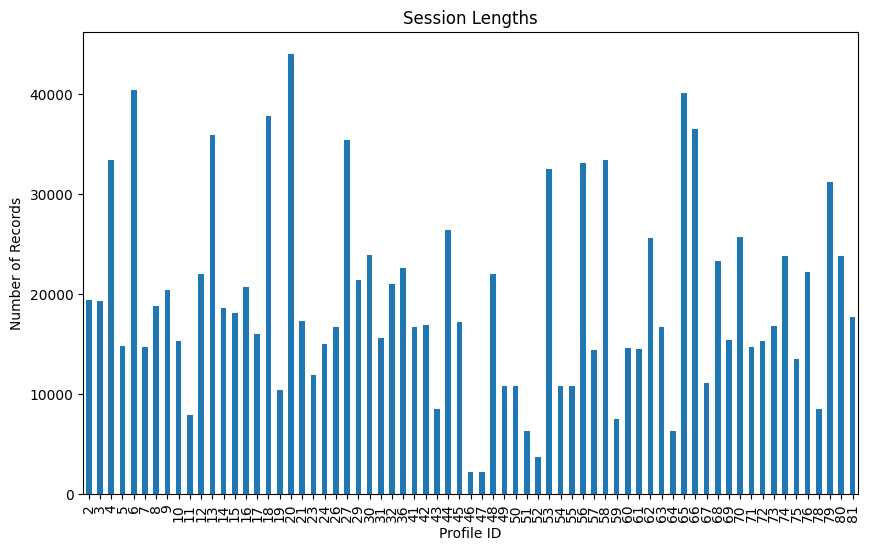

In [106]:
# Calculate the session lengths
session_lengths = df['profile_id'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
session_lengths.plot(kind='bar')
plt.title('Session Lengths')
plt.xlabel('Profile ID')
plt.ylabel('Number of Records')
plt.show()

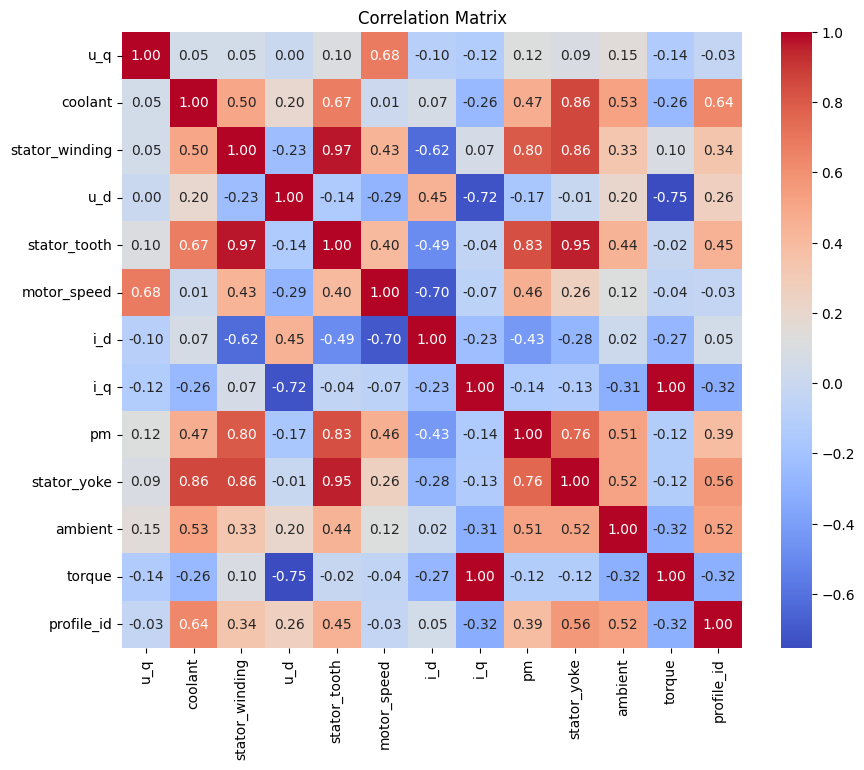

In [107]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, various insights are shown:

+ i_q and torque are directly correlated. This is due to the fact that i_q is the current variable which is directly responsable to the torque control in PMSMs.
+ stator_yoke, stator_tooth and stator_winding, all temperatures related to the stator mechanical part, all share a high correlation among them.
+ stator_yoke also shows a high correlation (0.86) with the coolant variable, which is the coolant temperature.


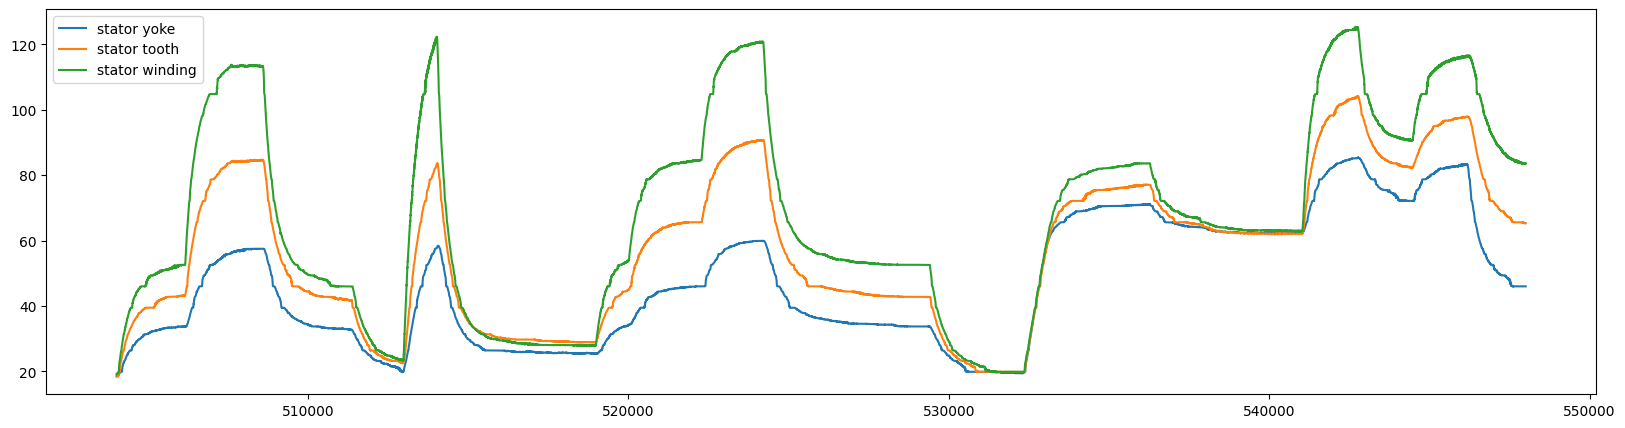

In [108]:
#visualize the correlation between the temperature stator yoke, stator tooth and stator winding
plt.figure(figsize=(20,5))
df[df['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
df[df['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
df[df['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
plt.legend()

# Feature Engineering

Let's start by normalize our data, excluding the "profile_id" variable.

In [109]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [110]:
df_norm = apply_z_score_normalization_except_profile_id(df)

Now let's enhance the DataFrame by adding Exponentially Weighted Average (EWA) features for each original column.

In [111]:
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [112]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(df_norm, spans, exclude_columns)

data_df.head()

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   u_q                   1330816 non-null  float64
 1   coolant               1330816 non-null  float64
 2   stator_winding        1330816 non-null  float64
 3   u_d                   1330816 non-null  float64
 4   stator_tooth          1330816 non-null  float64
 5   motor_speed           1330816 non-null  float64
 6   i_d                   1330816 non-null  float64
 7   i_q                   1330816 non-null  float64
 8   pm                    1330816 non-null  float64
 9   stator_yoke           1330816 non-null  float64
 10  ambient               1330816 non-null  float64
 11  torque                1330816 non-null  float64
 12  profile_id            1330816 non-null  int64  
 13  u_q_ewa_600           1330816 non-null  float64
 14  coolant_ewa_600       1330816 non-

In [129]:
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,coolant_ewa_600,u_d_ewa_600,stator_tooth_ewa_600,motor_speed_ewa_600,i_d_ewa_600,i_q_ewa_600,pm_ewa_600,stator_yoke_ewa_600,ambient_ewa_600,torque_ewa_600
count,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,...,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000,14656.000000
mean,-0.384516,0.612639,0.048953,0.322360,0.179279,-0.375613,0.347442,-0.331186,-0.044153,0.365954,...,0.606993,0.322537,0.155465,-0.381114,0.352219,-0.331777,-0.087914,0.345564,-0.553220,-0.333756
std,0.995001,1.014026,0.615261,0.859606,0.743529,0.994632,0.886631,0.918871,0.711798,0.882579,...,0.967375,0.355569,0.738836,0.396279,0.308357,0.437714,0.747551,0.872251,0.166674,0.428872
min,-1.281903,-0.543994,-1.490508,-1.661420,-1.482704,-1.184139,-2.433791,-3.577729,-1.873906,-1.250807,...,-0.533187,-0.677048,-1.475932,-1.184076,-0.546637,-1.469851,-1.858494,-1.249168,-0.750296,-1.464731
25%,-1.246909,-0.153003,-0.461653,0.153182,-0.474569,-1.184128,-0.330122,-0.402729,-0.741828,-0.427537,...,-0.154078,0.073815,-0.408227,-0.683601,0.155176,-0.590875,-0.787101,-0.317502,-0.722398,-0.594636
50%,-0.762596,-0.124858,0.089205,0.413422,0.064259,-0.873828,0.956573,-0.393953,0.280013,0.052326,...,0.008976,0.386959,0.111243,-0.455458,0.388477,-0.356640,0.285458,0.079549,-0.595189,-0.358642
75%,0.365434,1.364552,0.599793,0.448940,0.879209,0.361478,1.027454,-0.213419,0.455114,1.035392,...,1.273995,0.538071,0.769520,-0.152222,0.599122,-0.131808,0.432034,1.042507,-0.419204,-0.141454
max,1.756299,2.640464,1.340972,2.425641,1.695841,2.014283,1.027527,2.825344,0.999694,2.113603,...,2.526356,1.203234,1.501019,1.029107,1.027462,1.075746,0.862125,2.031776,-0.206813,1.026253


In [113]:
# Hyperparameters (downsampling, train/dev/test-split, feature selection, ...)
downsample_rate = 4
n_dev = 2 
n_test = 1
features = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'u_s', 'i_s', 's_el']
feature_len = len(features)
target = ['stator_winding']

In [114]:
IDs = np.array(data_df['profile_id'].unique())

In [115]:
# Creates single sample array of shape (1, T, n)
def get_single_sample(df, n_feat, sample_len, downsample_rate=1):
    
    # Get new length for downsampling
    new_len = int(np.floor((max_len + downsample_rate - 1) / downsample_rate) * downsample_rate)
    
    # Convert df to numpy array of shape (1, T, n)
    arr = df.to_numpy()
    arr = np.expand_dims(arr, axis=0)
    
    # Zero-pad to sample_len at the end of the array
    _arr = np.zeros((1, new_len - np.size(arr, 1), n_feat))
    sample = np.concatenate((arr, _arr), axis=1)
    
    # Get sample_weights (zero-padded elements should have zero weight)
    weights = np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=1)
    weights = weights[:,:,0]
    
    # Perform Downsampling
    dwn_sample = []
    dwn_weights = []
    for d in np.arange(1,downsample_rate+1):
        dwn_sample.append(sample[:,(-1+d)::downsample_rate,:])
        dwn_weights.append(weights[:,(-1+d)::downsample_rate])
    
    sample = np.concatenate(dwn_sample, axis=0)
    weights = np.concatenate(dwn_weights, axis=0)
        
    return sample, weights


## Derive additional features, create batches and train/dev/test-split

In [116]:
features = data_df.columns

features = [elem for elem in features if elem != 'stator_winding']
features = [elem for elem in features if elem != 'profile_id']
feature_len = len(features)

print(features)

print(len(features))

['u_q', 'coolant', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600', 'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600', 'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600', 'torque_ewa_600']
22


In [117]:
# Prepare Data for use with LSTMs: Data needs to be in shape (m, T, n)

# get maximum length, select features and target
max_len = data_df.groupby(['profile_id']).size().max()
print(max_len)

# Prepare index for faster iteration
iter_df = data_df.copy() # copy increases memory use, but avoids errors when executed twice. Better solution?
iter_df['idx'] = data_df.index
iter_df.set_index(['profile_id', 'idx'], inplace = True)

# create (m, T, n) array for X_values, sample_weights and Y_values
batch_samples_X = []
batch_weights_X = []
batch_samples_Y = []

for pid in IDs:
    # select profile
    df = iter_df.loc[pid]
    # get X samples and weights
    sample, weights = get_single_sample(df[features], 22, max_len, downsample_rate)
    batch_samples_X.append(sample)
    batch_weights_X.append(weights)    
    # get Y samples
    sample, _ = get_single_sample(df[target], 1, max_len, downsample_rate)
    batch_samples_Y.append(sample)
    
X_vals = np.concatenate(batch_samples_X, axis=0)
X_weights = np.concatenate(batch_weights_X, axis=0)
Y_vals = np.concatenate(batch_samples_Y, axis=0)

print('Shape of batches')
print('X_vals:    ', X_vals.shape)
print('X_weights: ', X_weights.shape)
print('Y_vals:    ', Y_vals.shape)

43971
Shape of batches
X_vals:     (276, 10993, 22)
X_weights:  (276, 10993)
Y_vals:     (276, 10993, 1)


In [118]:
# Create train-dev-test-split for LSTMs
# (when cycles are downsampled, all downsampled parts should belong to the same set)
X_train = X_vals[:-(n_dev+n_test)*downsample_rate,:,:]
X_train_weights = X_weights[:-(n_dev+n_test)*downsample_rate,:]
Y_train = Y_vals[:-(n_dev+n_test)*downsample_rate,:,:]

X_dev = X_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]
X_dev_weights = X_weights[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:]
Y_dev = Y_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]

X_test = X_vals[-((n_test)*downsample_rate):,:,:]
X_test_weights = X_weights[-((n_test)*downsample_rate):,:]
Y_test = Y_vals[-((n_test)*downsample_rate):,:,:]

print('Shape of train-test-split')
print('train (X, weights, Y): ', X_train.shape, X_train_weights.shape, Y_train.shape)
print('dev (X, weights, Y):   ', X_dev.shape, X_dev_weights.shape, Y_dev.shape)
print('test (X, weights, Y):  ', X_test.shape, X_test_weights.shape, Y_test.shape)


Shape of train-test-split
train (X, weights, Y):  (264, 10993, 22) (264, 10993) (264, 10993, 1)
dev (X, weights, Y):    (8, 10993, 22) (8, 10993) (8, 10993, 1)
test (X, weights, Y):   (4, 10993, 22) (4, 10993) (4, 10993, 1)


# Model Building

In [119]:
n_epochs = 15
lr = 0.01
lr_decay = 1e-2
dropout_rate = 0.1
n_units = 32
n_dense_in = 16
n_dense_mid = 8
n_dense_out = 1

In [120]:
# Plots the loss over all epochs and a zoom on the last 20 epochs.
def plot_learning_curves(history, descr=' '):

    # get results
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss)) 
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # loss
    axes[0].plot(epochs, loss, 'r')
    axes[0].plot(epochs, val_loss, 'b')
    axes[0].set_title('Loss - Train vs. Validation')
    axes[0].legend(['Train', 'Validation'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('loss')
    
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')
    
    return

## Unidirectional LSTM
First, let's start with a simple LSTM with a total of 7697 parameters.

In [121]:
simple_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, feature_len]),
  tf.keras.layers.Dense(n_dense_mid, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_out),
])

simple_lstm.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

simple_lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('Training...')

history = simple_lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=1)

print('Training Completed')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 32)          7040      
                                                                 
 dense_10 (Dense)            (None, None, 8)           264       
                                                                 
 dropout_5 (Dropout)         (None, None, 8)           0         
                                                                 
 dense_11 (Dense)            (None, None, 1)           9         
                                                                 
Total params: 7313 (28.57 KB)
Trainable params: 7313 (28.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training...
Epoch 1/15
9/9 [==============================] - ETA: 0s - loss: 0.1351 - mse: 0.1378WARNING:tensorflow:`evaluate()` received a value for `

9/9 [==============================] - 25s 3s/step - loss: 0.1351 - mse: 0.1378 - val_loss: 0.0281 - val_mse: 0.0318
Epoch 2/15
9/9 [==============================] - ETA: 0s - loss: 0.0408 - mse: 0.0428WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0408 - mse: 0.0428 - val_loss: 0.0234 - val_mse: 0.0238
Epoch 3/15
9/9 [==============================] - ETA: 0s - loss: 0.0323 - mse: 0.0337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0323 - mse: 0.0337 - val_loss: 0.0133 - val_mse: 0.0153
Epoch 4/15
9/9 [==============================] - ETA: 0s - loss: 0.0268 - mse: 0.0288WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 25s 3s/step - loss: 0.0268 - mse: 0.0288 - val_loss: 0.0107 - val_mse: 0.0123
Epoch 5/15
9/9 [==============================] - ETA: 0s - loss: 0.0241 - mse: 0.0260WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 25s 3s/step - loss: 0.0241 - mse: 0.0260 - val_loss: 0.0105 - val_mse: 0.0123
Epoch 6/15
9/9 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0246WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0225 - mse: 0.0246 - val_loss: 0.0092 - val_mse: 0.0110
Epoch 7/15
9/9 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0212 - mse: 0.0233 - val_loss: 0.0075 - val_mse: 0.0094
Epoch 8/15
9/9 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0223WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0202 - mse: 0.0223 - val_loss: 0.0065 - val_mse: 0.0085
Epoch 9/15
9/9 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0220WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 23s 3s/step - loss: 0.0195 - mse: 0.0220 - val_loss: 0.0053 - val_mse: 0.0076
Epoch 10/15
9/9 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0215WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0190 - mse: 0.0215 - val_loss: 0.0051 - val_mse: 0.0075
Epoch 11/15
9/9 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0213WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0184 - mse: 0.0213 - val_loss: 0.0056 - val_mse: 0.0081
Epoch 12/15
9/9 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0214WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0182 - mse: 0.0214 - val_loss: 0.0045 - val_mse: 0.0074
Epoch 13/15
9/9 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0212WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0179 - mse: 0.0212 - val_loss: 0.0041 - val_mse: 0.0071
Epoch 14/15
9/9 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0211WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0176 - mse: 0.0211 - val_loss: 0.0037 - val_mse: 0.0069
Epoch 15/15
9/9 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0213WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 28s 3s/step - loss: 0.0176 - mse: 0.0213 - val_loss: 0.0041 - val_mse: 0.0073
Training Completed


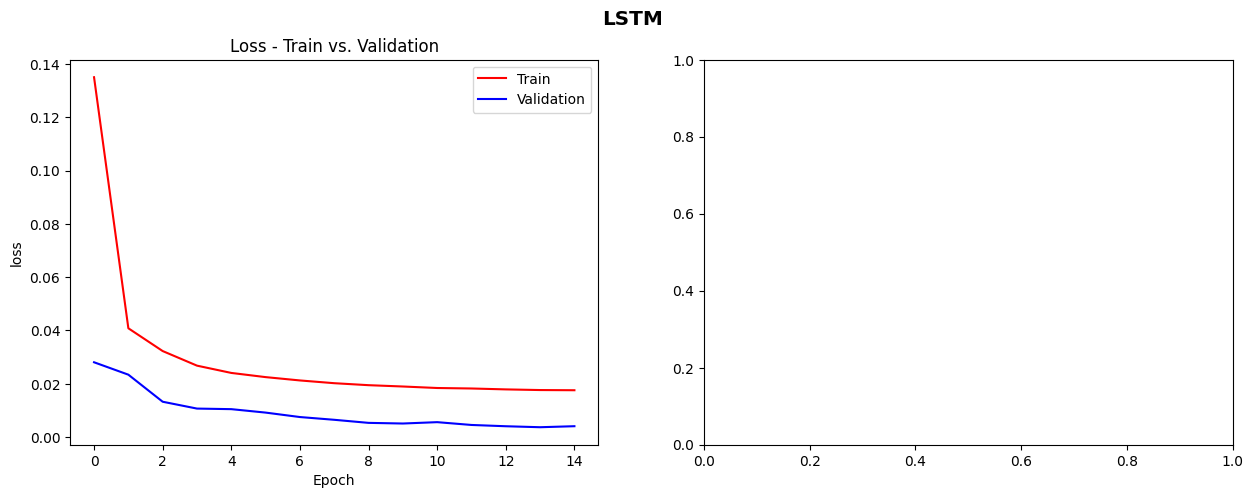

In [122]:
plot_learning_curves(history, descr = 'LSTM')

# Model Evaluation
* Optimizing metric is MSE (mean squared error).
* An arbitrary load cycle from the training set is plotted to show and validate training results.
* The worst load cycle from the dev set is plotted for hyperparameter tuning.

## Shared utils for evaluation

In [123]:
# This function makes a prediction on a given X of shape (1,Tx,1).
# The first skip_values are truncated, because initial temperature states may have large error.
# Also, only "not-zero-padded" part of the sequence is taken into account (-> sample_weight = 1).
def eval_model(model, X, Y, weights, skip_values=10, scaler=None):
    # prepare data for prediction
    end_sequence = np.where(weights==0)[1][0] # get "real" (= not-zero-padded) end of sequence
    X_pred = X[:,:end_sequence,:]
    Y_truth = Y[0,:end_sequence,0]

    # predict (and rescale if necessary)
    Y_pred = model.predict(X_pred)
    if scaler:
        Y_pred = scaler.inverse_transform(Y_pred)     
    Y_pred = Y_pred[0,:,0]
    
    # skip the first few values (large errors due to initialization phase)
    Y_pred = Y_pred[skip_values:]
    Y_truth = Y_truth[skip_values:]
        
    # calculate errors
    abs_error = np.abs(Y_pred-Y_truth)
    mse_error = np.mean(abs_error**2)    
    
    return Y_pred, Y_truth, abs_error, mse_error

# This function outputs a plot showing the prediction vs. ground truth and the corresponding error.
def plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr=' '):

    fig, axes = plt.subplots(1, 2, sharex = True, figsize=(15, 5))

    # Temperature values
    axes[0].plot(Y_truth, 'r')
    axes[0].plot(Y_pred, 'b')
    axes[0].set_title('Prediction vs. ground truth')
    axes[0].legend(['Truth', 'Prediction'])
    axes[0].set_xlabel('sample')
    axes[0].set_ylabel('Temperature')
    
    # Error
    axes[1].plot(abs_error, 'r')
    axes[1].set_title('Error (total MSE: {:.5f})'.format(mse_error))
    axes[1].set_xlabel('sample')
    axes[1].set_ylabel('Error')
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')

    return

## Unidirectional LSTM
In accordance to the research paper, a simple model with relatively few parameters can already reach descent accuracy of the temperature estimation.

1/1 [==============================] - 0s 482ms/step


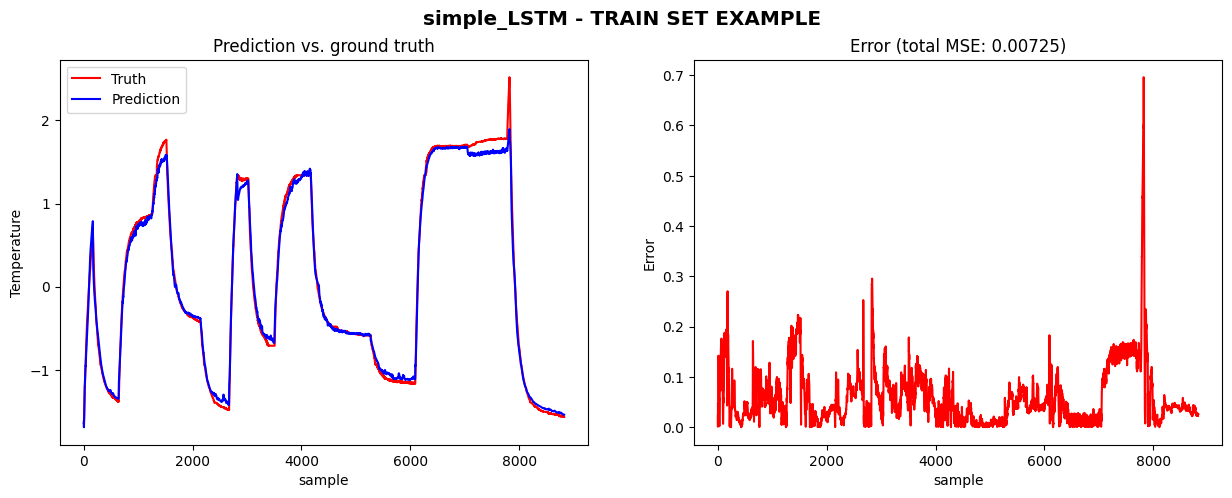

In [124]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - TRAIN SET EXAMPLE')

1/1 [==============================] - 0s 362ms/step
Test MSE for profile ID 3: 0.01183


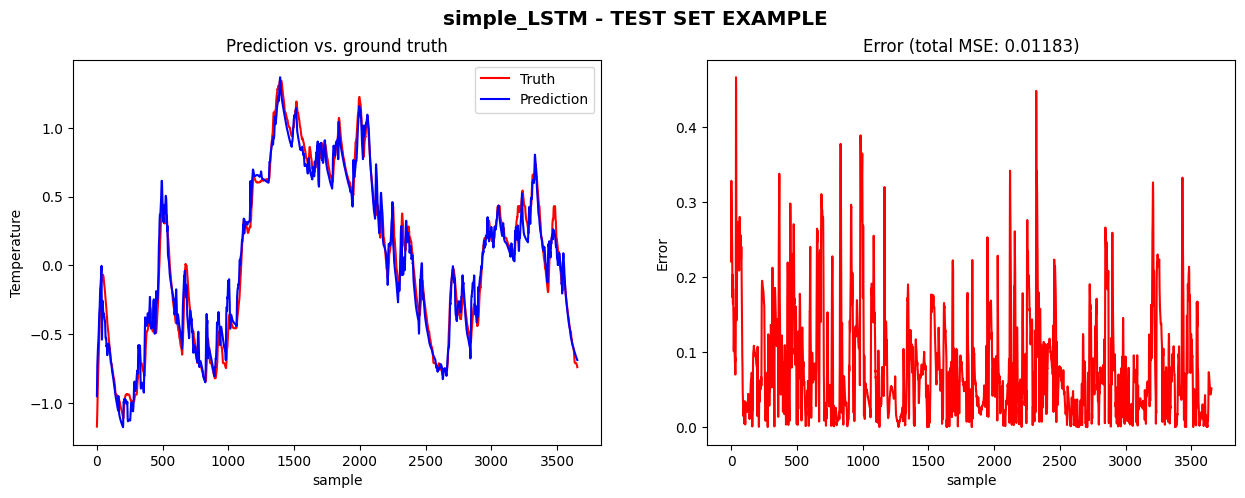

In [125]:
# Pick a random load cycle from the testing set for evaluation
pid_test = np.random.choice(len(X_test))  # Replace with a specific ID if needed
X_pred_test = X_test[pid_test:pid_test+1,:,:]
Y_truth_test = Y_test[pid_test:pid_test+1,:,:]
weights_test = X_test_weights[pid_test:pid_test+1,:]

# Evaluate the model
Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test = eval_model(simple_lstm, X_pred_test, Y_truth_test, weights_test)

# Plot the prediction vs. ground truth for the testing set
plot_prediction(Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test, descr='simple_LSTM - TEST SET EXAMPLE')

# Print out the MSE for this particular testing sample
print(f'Test MSE for profile ID {pid_test}: {mse_error_test:.5f}')


In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the entire testing set
Y_pred_test_all = simple_lstm.predict(X_test)
Y_truth_test_all = Y_test.squeeze()

# Reshape predictions and true values for metric calculations
Y_pred_test_all_flat = Y_pred_test_all.ravel()
Y_truth_test_all_flat = Y_truth_test_all.ravel()

# Calculate MSE
mse_test = mean_squared_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

# Calculate MAE
mae_test = mean_absolute_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate R-squared
r2_test = r2_score(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Print the metrics
print(f'Test MSE: {mse_test:.5f}')
print(f'Test RMSE: {rmse_test:.5f}')
print(f'Test MAE: {mae_test:.5f}')
print(f'Test R-squared: {r2_test:.5f}')


1/1 [==============================] - 0s 260ms/step
Test MSE: 0.00829
Test RMSE: 0.09106
Test MAE: 0.08035
Test R-squared: 0.93455


## ResLSTM
The ResLSTM adds residual connections to the architecture using keras functional API. The Dense layers and number of nodes of the LSTMs will be the same as the Unidirectional LSTM model.

In [126]:

# Define the learning rate schedule
initial_learning_rate = lr  # Set your initial learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,  # Adjust as per your requirements
    decay_rate=0.96,     # Adjust the decay rate as needed
    staircase=True)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Build your model as before
inputs = tf.keras.layers.Input(shape=[None, feature_len])

# Single LSTM layer
out_1 = tf.keras.layers.LSTM(n_units, return_sequences=True)(inputs)

# Simplified Dense Layers
x = tf.keras.layers.Dense(n_dense_in, activation="relu")(out_1)
# Optional: Dropout layer if overfitting is observed
x = tf.keras.layers.Dropout(dropout_rate)(x)
y = tf.keras.layers.Dense(n_dense_out)(x)

# Create model
simplified_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)

# Compile the model
res_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)
res_lstm.summary()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 22)]        0         
                                                                 
 lstm_6 (LSTM)               (None, None, 32)          7040      
                                                                 
 dense_12 (Dense)            (None, None, 16)          528       
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 dense_13 (Dense)            (None, None, 1)           17        
                                                                 
Total params: 7585 (29.63 KB)
Trainable params: 7585 (29.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
res_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = res_lstm.fit(
    x=X_train, 
    y=Y_train, 
    validation_data=(X_dev, Y_dev, X_dev_weights), 
    sample_weight=X_train_weights, 
    epochs=n_epochs,
    verbose=1)

print('Training Completed')

Epoch 1/15
9/9 [==============================] - ETA: 0s - loss: 0.1293 - mse: 0.1354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 26s 3s/step - loss: 0.1293 - mse: 0.1354 - val_loss: 0.1152 - val_mse: 0.1300
Epoch 2/15
9/9 [==============================] - ETA: 0s - loss: 0.0469 - mse: 0.0588WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 24s 3s/step - loss: 0.0469 - mse: 0.0588 - val_loss: 0.0217 - val_mse: 0.0337
Epoch 3/15
1/9 [==>...........................] - ETA: 21s - loss: 0.0339 - mse: 0.0476

KeyboardInterrupt: 

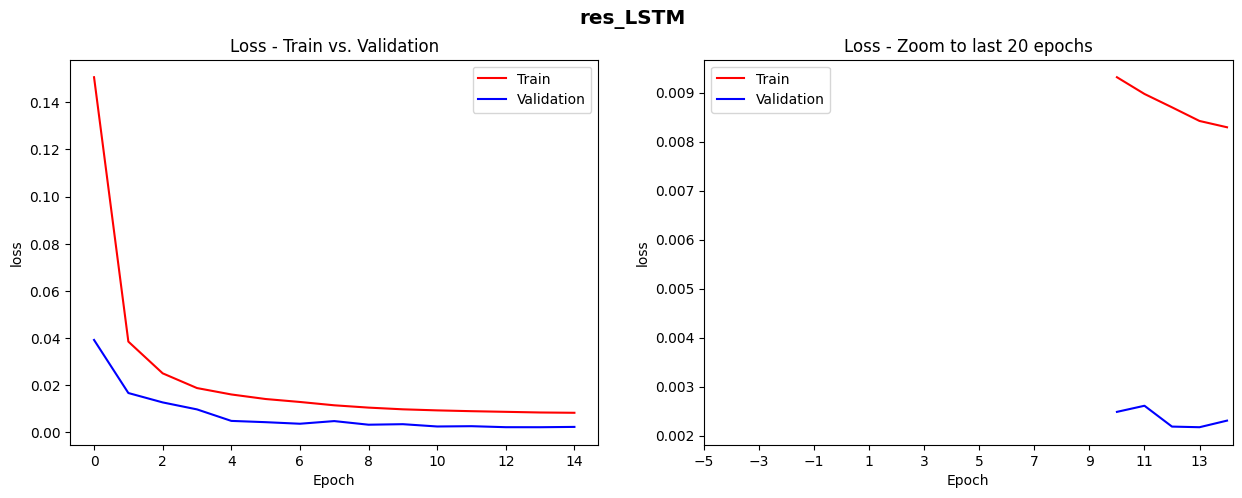

In [ ]:
plot_learning_curves(history, descr='res_LSTM')

1/1 [==============================] - 1s 875ms/step


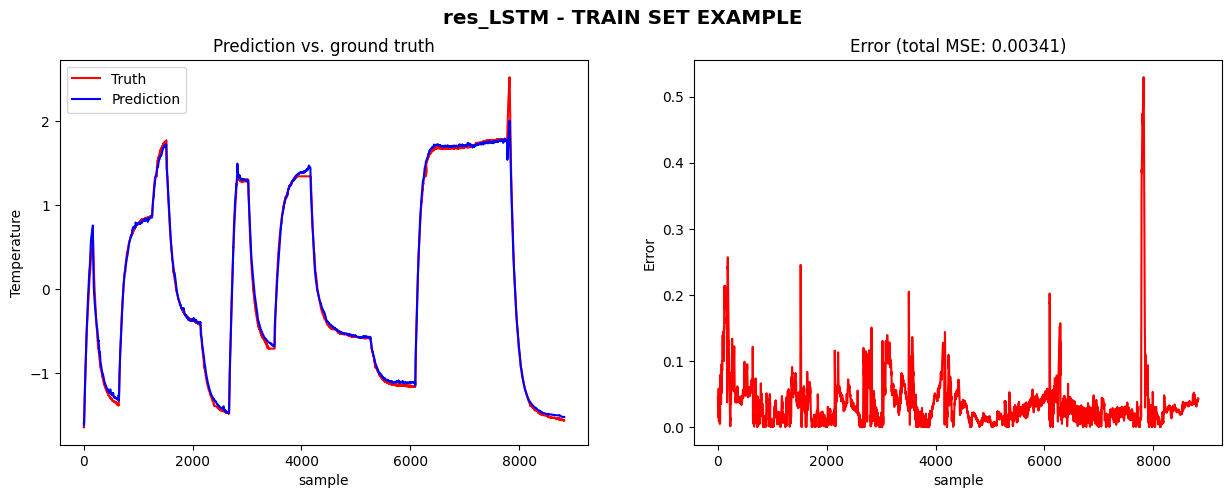

In [ ]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - TRAIN SET EXAMPLE')

In [ ]:
# Pick a random load cycle from the testing set for evaluation
pid_test = np.random.choice(len(X_test))  # Replace with a specific ID if needed
X_pred_test = X_test[pid_test:pid_test+1,:,:]
Y_truth_test = Y_test[pid_test:pid_test+1,:,:]
weights_test = X_test_weights[pid_test:pid_test+1,:]

# Evaluate the model
Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test = eval_model(res_lstm, X_pred_test, Y_truth_test, weights_test)

# Plot the prediction vs. ground truth for the testing set
plot_prediction(Y_pred_test, Y_truth_test_arr, abs_error_test, mse_error_test, descr='simple_LSTM - TEST SET EXAMPLE')

# Print out the MSE for this particular testing sample
print(f'Test MSE for profile ID {pid_test}: {mse_error_test:.5f}')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the entire testing set
Y_pred_test_all = res_lstm.predict(X_test)
Y_truth_test_all = Y_test.squeeze()

# Reshape predictions and true values for metric calculations
Y_pred_test_all_flat = Y_pred_test_all.ravel()
Y_truth_test_all_flat = Y_truth_test_all.ravel()

# Calculate MSE
mse_test = mean_squared_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

# Calculate MAE
mae_test = mean_absolute_error(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Calculate R-squared
r2_test = r2_score(Y_truth_test_all_flat, Y_pred_test_all_flat)

# Print the metrics
print(f'Test MSE: {mse_test:.5f}')
print(f'Test RMSE: {rmse_test:.5f}')
print(f'Test MAE: {mae_test:.5f}')
print(f'Test R-squared: {r2_test:.5f}')